# Symptom Prediction

## 1) Loading Data and Packages + Util

In [1]:
import os
from google.colab import files
import shutil

import math
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score, RandomizedSearchCV, GridSearchCV, TunedThresholdClassifierCV, cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score, make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import get_scorer_names, balanced_accuracy_score
import matplotlib.pyplot as plt
from typing_extensions import final
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

Load data from local folder

In [2]:
os.makedirs('/content/data', exist_ok=True)
destination_folder = '/content/data'
uploaded = files.upload()
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(destination_folder, filename))

Saving all_fitbit_data_daily_w_visit.csv to all_fitbit_data_daily_w_visit.csv
Saving data_daily_w_visits.csv to data_daily_w_visits.csv
Saving adh.csv to adh.csv


Setup fitbit_data

In [3]:
fitbit_data = pd.read_csv('/content/data/data_daily_w_visits.csv')

In [4]:
all_fitbit_data = pd.read_csv('/content/data/all_fitbit_data_daily_w_visit.csv')

In [5]:
adh_data = pd.read_csv('/content/data/adh.csv')

In [6]:
# Organizing columns
measure_features = ['calories', 'heart', 'steps']
survey_features = ['diet', 'medication', 'symptoms']
target_col = 'symptoms'
all_features = ['avgWeight_per_day',
       'calories', 'heart', 'steps', 'minutes_asleep', 'minutes_awake', 'temp/skin_nightlyRelative',
       'spo2_avg', 'spo2_min', 'spo2_max', 'hrv_dailyRmssd', 'hrv_deepRmssd',
       'br_breathingRate', 'out_of_range_zone_cal', 'out_of_range_zone_max_hr',
       'out_of_range_zone_min_hr', 'fat_burn_zone_cal', 'fat_burn_zone_max_hr',
       'fat_burn_zone_min_hr', 'cardio_zone_cal', 'cardio_zone_max_hr',
       'cardio_zone_min_hr', 'peak_zone_cal', 'peak_zone_max_hr',
       'peak_zone_min_hr', 'diet_response_0.0', 'diet_response_1.0',
       'diet_response_2.0', 'diet_response_nan', 'medication_response_0.0',
       'medication_response_1.0', 'medication_response_2.0',
       'medication_response_nan', 'symptoms_response_0.0',
       'symptoms_response_1.0', 'symptoms_response_2.0',
       'symptoms_response_nan']
one_h_feaatures = ['diet_response_0.0', 'diet_response_1.0',
       'diet_response_2.0', 'diet_response_nan', 'medication_response_0.0',
       'medication_response_1.0', 'medication_response_2.0',
       'medication_response_nan', 'symptoms_response_0.0',
       'symptoms_response_1.0', 'symptoms_response_2.0',
       'symptoms_response_nan']

In [16]:
def compute_metrics(y_true, y_prob, thresh: float = 0.5):
    y_pred = (y_prob > thresh).astype(int)
    auroc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
    auprc = average_precision_score(y_true, y_prob)
    acc = accuracy_score(y_true,y_pred)
    cm = confusion_matrix(y_true,y_pred)

    return acc, auroc, auprc, cm

## 2) Analyzing + Transforming Data

Preliminary setup

In [7]:
# Ensure date is datetime and sort
fitbit_data['date'] = pd.to_datetime(fitbit_data['date'])
fitbit_data = fitbit_data.sort_values(by=['fitbit_user_id', 'date'])
all_fitbit_data['date'] = pd.to_datetime(all_fitbit_data['date'])
all_fitbit_data = all_fitbit_data.sort_values(by=['fitbit_user_id', 'date'])

# Shift survey columns
for col in survey_features:
  fitbit_data[col] = fitbit_data.groupby('fitbit_user_id')[col].shift(-1)
  all_fitbit_data[col] = all_fitbit_data.groupby('fitbit_user_id')[col].shift(-1)

# Set remaining nan visit columns to 0
fitbit_data[target_col] = fitbit_data[target_col].fillna(0)
all_fitbit_data[target_col] = all_fitbit_data[target_col].fillna(0)

One hot encode

In [8]:
# One hot encode
fitbit_data = pd.get_dummies(
    fitbit_data,
    columns=survey_features,
    prefix=[col + '_response' for col in survey_features],
    dummy_na=True,
    dtype=float
)

all_fitbit_data = pd.get_dummies(
    all_fitbit_data,
    columns=survey_features,
    prefix=[col + '_response' for col in survey_features],
    dummy_na=True,
    dtype=float
)

In [9]:
fitbit_data_w_visits = fitbit_data[fitbit_data['visit_day'] == 1].reset_index(drop=True)
fitbit_data_w_visits

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,minutes_asleep,minutes_awake,...,diet_response_2.0,diet_response_nan,medication_response_0.0,medication_response_1.0,medication_response_2.0,medication_response_nan,symptoms_response_0.0,symptoms_response_1.0,symptoms_response_2.0,symptoms_response_nan
0,921,2021-08-31,App Money,7,NaN,2305.0,102.0,2609.0,462.0,46.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,950,2021-09-29,App Money,7,NaN,1898.0,NaN,915.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,959,2021-10-08,App Money,7,NaN,1736.0,NaN,0.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,991,2021-11-09,App Money,7,NaN,1736.0,NaN,0.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1020,2021-12-08,App Money,7,NaN,2379.0,96.0,2210.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,40015,2024-05-26,No App,272,NaN,1055.0,NaN,802.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
76,40024,2024-06-04,No App,272,NaN,1832.0,88.0,14633.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
77,41361,2024-09-19,App Money,279,161.819108,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
78,41632,2024-07-07,App Money,284,241.626352,2584.0,76.0,2694.0,122.0,17.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
(all_fitbit_data.isna().sum() / len(all_fitbit_data)).sort_values(ascending=False)

In [ ]:
fitbit_data

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,minutes_asleep,minutes_awake,...,diet_response_2.0,diet_response_nan,medication_response_0.0,medication_response_1.0,medication_response_2.0,medication_response_nan,symptoms_response_0.0,symptoms_response_1.0,symptoms_response_2.0,symptoms_response_nan
0,0,2021-07-27,App Money,1,228.619094,2879.0,66.0,6260.0,NaN,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,2021-07-28,App Money,1,227.560876,3207.0,66.0,10805.0,270.0,46.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2,2021-07-29,App Money,1,227.186091,2911.0,67.0,8292.0,141.0,23.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,3,2021-07-30,App Money,1,225.973550,3301.0,66.0,8250.0,172.0,53.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,4,2021-07-31,App Money,1,225.459139,3106.0,66.0,7704.0,99.0,5.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44815,44815,2025-03-12,No App,307,NaN,2244.0,64.0,3297.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
44816,44816,2025-03-13,No App,307,NaN,2152.0,63.0,3730.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
44817,44817,2025-03-14,No App,307,NaN,2529.0,64.0,6657.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
44818,44818,2025-03-15,No App,307,NaN,2494.0,64.0,7626.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
fitbit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44820 entries, 0 to 44819
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Unnamed: 0               44820 non-null  int64         
 1   date                     44820 non-null  datetime64[ns]
 2   study_group              44820 non-null  object        
 3   fitbit_user_id           44820 non-null  int64         
 4   avgWeight_per_day        32886 non-null  float64       
 5   calories                 41396 non-null  float64       
 6   heart                    34401 non-null  float64       
 7   steps                    41358 non-null  float64       
 8   minutes_asleep           30702 non-null  float64       
 9   minutes_awake            30702 non-null  float64       
 10  days                     44820 non-null  int64         
 11  admit_type               73 non-null     object        
 12  death                    80 non-

In [ ]:
fitbit_data.describe()

,Unnamed: 0,date,fitbit_user_id,avgWeight_per_day,calories,heart,steps,minutes_asleep,minutes_awake,days,...,diet_response_2.0,diet_response_nan,medication_response_0.0,medication_response_1.0,medication_response_2.0,medication_response_nan,symptoms_response_0.0,symptoms_response_1.0,symptoms_response_2.0,symptoms_response_nan
count,44820.000000,44820,44820.000000,32886.000000,41396.000000,34401.000000,41358.000000,30702.000000,30702.000000,44820.000000,...,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000,44820.000000
mean,22409.500000,2023-03-04 14:47:42.650602240,152.518072,189.784778,2235.929534,65.401733,5234.779148,383.079734,54.538662,89.500000,...,0.360018,0.471307,0.004462,0.019835,0.504507,0.471196,0.357854,0.156917,0.014123,0.471107
min,0.000000,2021-07-26 00:00:00,1.000000,33.951148,267.000000,36.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11204.750000,2022-05-26 00:00:00,80.000000,160.275874,1786.000000,60.000000,2201.000000,317.250000,36.000000,44.750000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,22409.500000,2023-02-16 00:00:00,152.000000,183.644846,2151.500000,64.000000,4441.000000,391.000000,53.000000,89.500000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,33614.250000,2023-11-08 00:00:00,222.000000,211.643520,2557.000000,72.000000,7291.000000,457.000000,70.000000,134.250000,...,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,44819.000000,2025-03-16 00:00:00,307.000000,398.705527,13442.000000,118.000000,37020.000000,1545.000000,435.000000,179.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,12938.563869,NaN,86.485919,45.383202,767.532572,9.289836,4163.937032,126.255121,29.144155,51.961302,...,0.480011,0.499182,0.066652,0.139434,0.499985,0.499175,0.479374,0.363726,0.118000,0.499170


In [ ]:
fitbit_data[target_col]

,visit_day
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
44815,0.0
44816,0.0
44817,0.0
44818,0.0


In [ ]:
fitbit_data[measure_features + one_h_feaatures + [target_col]].corr()

,avgWeight_per_day,calories,heart,steps,diet_response_0.0,diet_response_1.0,diet_response_2.0,diet_response_nan,medication_response_0.0,medication_response_1.0,medication_response_2.0,medication_response_nan,symptoms_response_0.0,symptoms_response_1.0,symptoms_response_2.0,symptoms_response_nan,visit_day
avgWeight_per_day,1.000000,0.373354,0.129531,-0.144976,-0.012775,0.115264,0.037072,-0.116215,0.026173,0.037068,0.100517,-0.116188,0.037277,0.057270,0.128357,-0.115703,-0.000209
calories,0.373354,1.000000,-0.023124,0.456305,-0.022520,0.036252,-0.007507,-0.009382,-0.001204,0.008699,0.006654,-0.009054,0.047490,-0.054580,0.015333,-0.009188,-0.015476
heart,0.129531,-0.023124,1.000000,-0.173048,-0.033483,0.015795,0.039888,-0.037826,0.033239,0.069086,0.012165,-0.038015,-0.024675,0.060177,0.062618,-0.037960,0.014878
steps,-0.144976,0.456305,-0.173048,1.000000,-0.014462,0.004755,0.038059,-0.035000,-0.014207,-0.012302,0.040083,-0.034741,0.138243,-0.112696,-0.063136,-0.035018,-0.030752
diet_response_0.0,-0.012775,-0.022520,-0.033483,-0.014462,1.000000,-0.075231,-0.143982,-0.181251,0.055853,0.091097,0.148067,-0.181211,0.072133,0.143803,0.028087,-0.180695,-0.002408
diet_response_1.0,0.115264,0.036252,0.015795,0.004755,-0.075231,1.000000,-0.293930,-0.370012,0.027959,0.118060,0.331891,-0.369140,0.259858,0.162634,0.005971,-0.369469,-0.005680
diet_response_2.0,0.037072,-0.007507,0.039888,0.038059,-0.143982,-0.293930,1.000000,-0.708156,0.024406,0.020650,0.697280,-0.707438,0.519989,0.252394,0.102067,-0.707405,-0.015198
diet_response_nan,-0.116215,-0.009382,-0.037826,-0.035000,-0.181251,-0.370012,-0.708156,1.000000,-0.063212,-0.133992,-0.951290,0.998702,-0.703621,-0.406719,-0.112628,0.998702,0.019373
medication_response_0.0,0.026173,-0.001204,0.033239,-0.014207,0.055853,0.027959,0.024406,-0.063212,1.000000,-0.009524,-0.067556,-0.063198,0.010076,0.053948,0.060072,-0.063187,0.005099
medication_response_1.0,0.037068,0.008699,0.069086,-0.012302,0.091097,0.118060,0.020650,-0.133992,-0.009524,1.000000,-0.143542,-0.134282,0.040013,0.120324,0.034505,-0.134258,0.001566


Missingness in columns

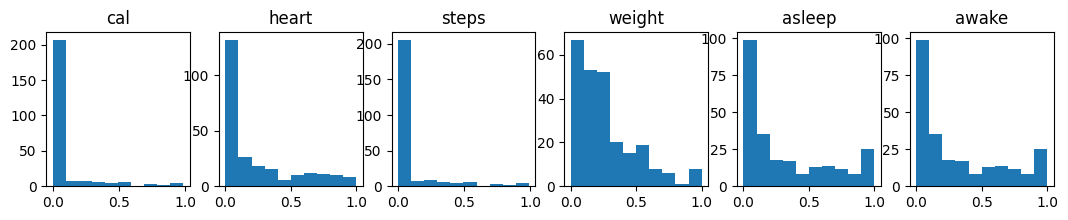

In [10]:
cal = []
heart = []
steps = []
weight = []
asleep = []
awake = []
for i in all_fitbit_data['fitbit_user_id'].unique():
    temp = all_fitbit_data[all_fitbit_data['fitbit_user_id']==i].reset_index(drop=True)
    cal += [temp['calories'].isna().sum()/len(temp)]
    heart += [temp['heart'].isna().sum()/len(temp)]
    steps += [temp['steps'].isna().sum()/len(temp)]
    weight += [temp['avgWeight_per_day'].isna().sum()/len(temp)]
    asleep += [temp['minutes_asleep'].isna().sum()/len(temp)]
    awake += [temp['minutes_awake'].isna().sum()/len(temp)]

fig, axs = plt.subplots(1,6,figsize=(13,2))
axs[0].hist(cal)
axs[0].set_title('cal')
axs[1].hist(heart)
axs[1].set_title('heart')
axs[2].hist(steps)
axs[2].set_title('steps')
axs[3].hist(weight)
axs[3].set_title('weight')
axs[4].hist(asleep)
axs[4].set_title('asleep')
axs[5].hist(awake)
axs[5].set_title('awake')
plt.show()

*   weight, sleep numbers are missing alot

See how many weeks/days should be removed given too many missing values

In [18]:
def windows_to_remove(df, features, max_nans = 3, window_days = 7):

  drop = 0
  count = 0

  for _,group in df.groupby('fitbit_user_id'):
    group = group.copy()

    for i in range(0, len(group), window_days):
      window = group.iloc[i:i+window_days]

      for feature in features:
        nan_count = window[feature].isna().sum()
        if nan_count >= max_nans:
          drop += 1
          break

      count += 1

  keep = count - drop

  return count, keep, drop

count, keep, drop = windows_to_remove(fitbit_data, measure_features)

keep/count

0.7567191844300278

## 3) Imputation

In [8]:
def fix_nans(df, features, max_nans=3, window_days=7):
    df = df.copy()
    cleaned_data = []

    for _, group in df.groupby('fitbit_user_id'):
        group = group.copy().reset_index(drop=True)
        feature_values = {feature: [] for feature in features}

        for i in range(0, len(group), window_days):
            window = group.iloc[i:i+window_days].copy()
            drop_window = False

            for feature in features:
                nan_count = window[feature].isna().sum()
                if nan_count >= max_nans:
                    drop_window = True

                for j in range(len(window)):
                    val = window.iloc[j][feature]
                    if pd.notna(val):
                        feature_values[feature].append(val)
                    else:
                        if len(feature_values[feature]) == 0:
                            drop_window = True
                        else:
                            mean_val = float(np.mean(feature_values[feature]))
                            feature_values[feature].append(mean_val)
                            window.loc[window.index[j], feature] = mean_val

            if not drop_window:
                cleaned_data.append(window)

    result_df = pd.concat(cleaned_data, ignore_index=True)
    return result_df

In [9]:
imputed_fb_data = fix_nans(fitbit_data, measure_features)

In [10]:
scaler = MinMaxScaler().fit(imputed_fb_data[measure_features])
imputed_fb_data[measure_features] = scaler.transform(imputed_fb_data[measure_features])

In [11]:
fb_data = imputed_fb_data.copy()

In [12]:
# Drop any columns with missing symptoms values
fb_data = fb_data.dropna(subset=target_col)

In [30]:
fb_data

,Unnamed: 0,date,study_group,fitbit_user_id,avgWeight_per_day,calories,heart,steps,diet,medication,symptoms,minutes_asleep,minutes_awake,days,admit_type,death,visit_day
0,0,2021-07-27,App Money,1,228.619094,0.188460,0.365854,0.176881,1.0,2.0,1.0,NaN,NaN,0,NaN,NaN,0.0
1,1,2021-07-28,App Money,1,227.560876,0.213660,0.365854,0.305304,1.0,2.0,0.0,270.0,46.0,1,NaN,NaN,0.0
2,2,2021-07-29,App Money,1,227.186091,0.190919,0.378049,0.234297,2.0,2.0,0.0,141.0,23.0,2,NaN,NaN,0.0
3,3,2021-07-30,App Money,1,225.973550,0.220882,0.365854,0.233110,2.0,2.0,0.0,172.0,53.0,3,NaN,NaN,0.0
4,4,2021-07-31,App Money,1,225.459139,0.205900,0.365854,0.217682,1.0,2.0,0.0,99.0,5.0,4,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33681,44606,2025-01-14,App Money,305,128.088422,0.059926,0.500000,0.055777,2.0,2.0,0.0,NaN,NaN,146,NaN,NaN,0.0
33682,44635,2025-02-12,App Money,305,129.190732,0.059158,0.573171,0.054562,2.0,2.0,0.0,NaN,NaN,175,NaN,NaN,0.0
33683,44636,2025-02-13,App Money,305,128.970270,0.051014,0.509388,0.014750,2.0,2.0,0.0,NaN,NaN,176,NaN,NaN,0.0
33684,44637,2025-02-14,App Money,305,128.308884,0.059312,0.573171,0.059055,2.0,2.0,0.0,NaN,NaN,177,NaN,NaN,0.0


# Random Forest

In [13]:
# Step 1: Get unique user IDs
unique_users = fb_data['fitbit_user_id'].unique()

# Step 2: Split user IDs into train/test
train, test = train_test_split(
    unique_users, test_size=0.2, random_state=42
)

# Step 3: Filter original DataFrame based on user ID
train = fb_data[fb_data['fitbit_user_id'].isin(train)].reset_index(drop=True)
test = fb_data[fb_data['fitbit_user_id'].isin(test)].reset_index(drop=True)

x_train = train[measure_features]
y_train = train[target_col]
x_test = test[measure_features]
y_test = test[target_col]

In [14]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

rf.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [17]:
# Predict class and probabilities
y_pred = rf.predict(x_test)
y_prob = rf.predict_proba(x_test)

# Metrics
compute_metrics(y_test, y_prob[:,1])

AxisError: axis 1 is out of bounds for array of dimension 1

CV

In [18]:
x = fb_data[measure_features+['fitbit_user_id']]
targets = fb_data[target_col]

sgkf = StratifiedGroupKFold(n_splits=5)

groups = x['fitbit_user_id']  # or however you track user grouping

In [19]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [36]:
cross_val_score(rf, x, targets, groups=groups, cv=sgkf, scoring="accuracy")

array([0.60044368, 0.55160579, 0.58449499, 0.54910605, 0.56048968])

In [ ]:
cross_val_score(rf, x, targets, groups=groups, cv=sgkf, scoring="f1_macro")

array([0.35732243, 0.27456861, 0.3005927 , 0.38209308, 0.33573947])

In [ ]:
cross_val_score(rf, x, targets, groups=groups, cv=sgkf, scoring="f1_weighted")

array([0.60723733, 0.530946  , 0.53694295, 0.62961411, 0.5842747 ])

In [ ]:
cross_val_score(rf, x, targets, groups=groups, cv=sgkf, scoring="roc_auc_ovr_weighted")

array([0.67258715, 0.4139447 , 0.47684694, 0.58741924, 0.55736323])

In [20]:
def train_evaluate_visualize(X_train, y_train, X_val, y_val, **params):
    classes = np.unique(y_train)
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    y_prob_train = model.predict_proba(X_train)
    y_prob_val = model.predict_proba(X_val)

    train_acc = accuracy_score(y_train, y_pred_train)
    val_acc = accuracy_score(y_val, y_pred_val)
    train_auc = roc_auc_score(y_train, y_prob_train, multi_class='ovr', average='weighted')
    val_auc = roc_auc_score(y_val, y_prob_val, multi_class='ovr', average='weighted')

    print(f"Train  Acc: {train_acc:.3f},  Validation Acc: {val_acc:.3f}")
    print(f"Train  AUC: {train_auc:.3f},  Validation AUC: {val_auc:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred_val, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # Multiclass ROC Curves
    y_val_bin = label_binarize(y_val, classes=classes)
    plt.figure()
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_prob_val[:, i])
        auc_score = roc_auc_score(y_val_bin[:, i], y_prob_val[:, i])
        plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Multiclass PR Curves
    plt.figure()
    for i, class_label in enumerate(classes):
        precision, recall, _ = precision_recall_curve(y_val_bin[:, i], y_prob_val[:, i])
        ap_score = average_precision_score(y_val_bin[:, i], y_prob_val[:, i])
        plt.plot(recall, precision, label=f'Class {class_label} (AP = {ap_score:.2f})')

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Multiclass Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

    return model, train_acc, val_acc, train_auc, val_auc

Train  Acc: 1.000,  Validation Acc: 0.773
Train  AUC: 1.000,  Validation AUC: 0.537


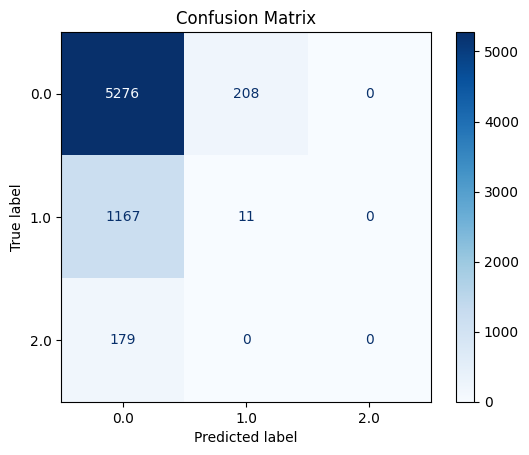

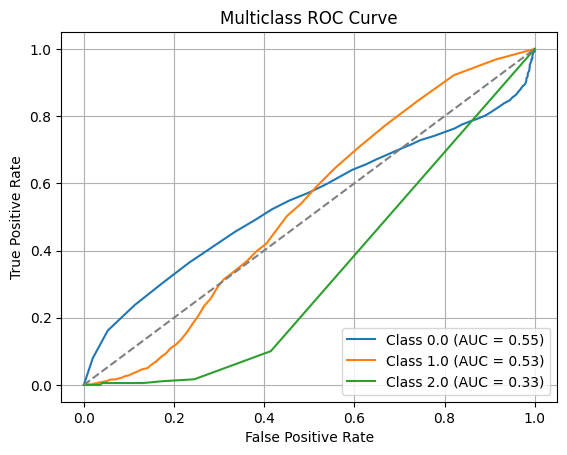

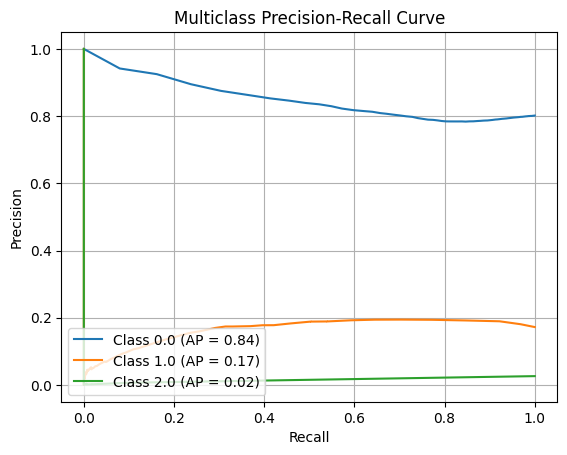

Train  Acc: 1.000,  Validation Acc: 0.707
Train  AUC: 1.000,  Validation AUC: 0.473


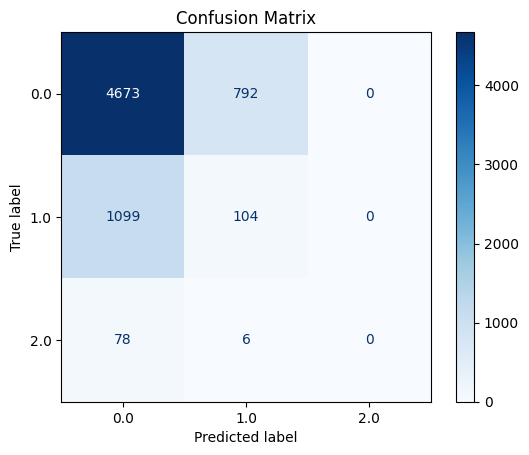

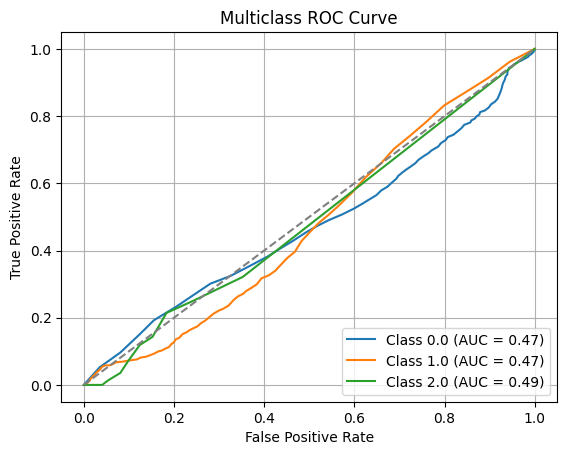

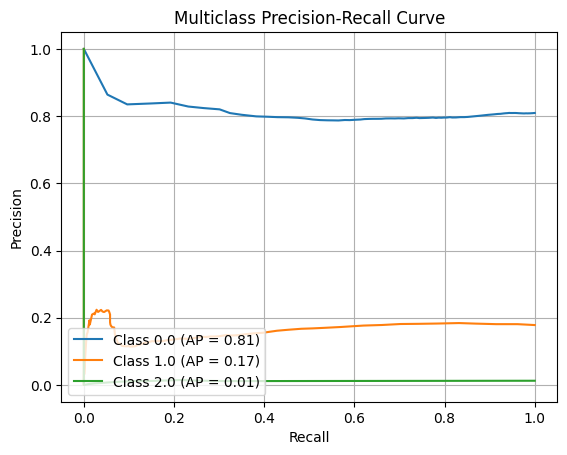

Train  Acc: 1.000,  Validation Acc: 0.755
Train  AUC: 1.000,  Validation AUC: 0.589


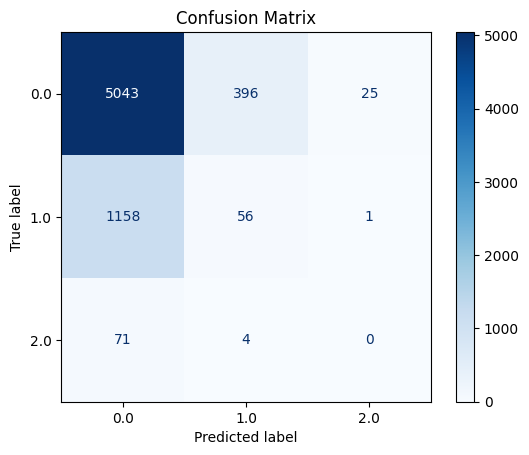

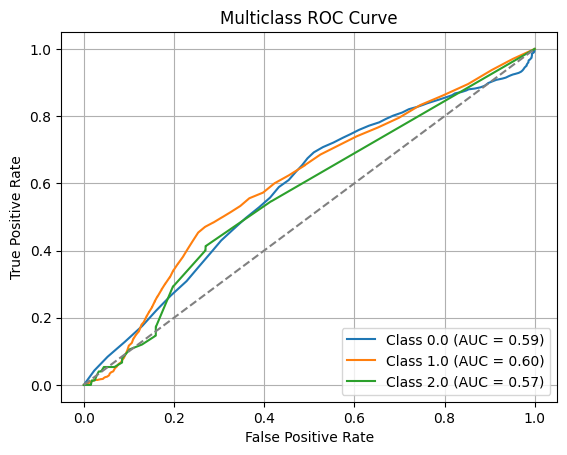

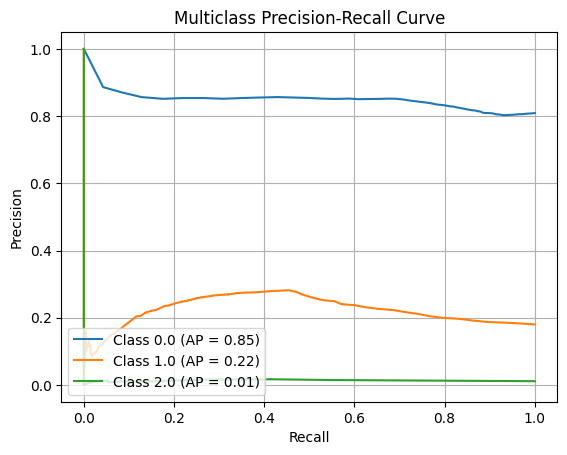

Train  Acc: 1.000,  Validation Acc: 0.748
Train  AUC: 1.000,  Validation AUC: 0.449


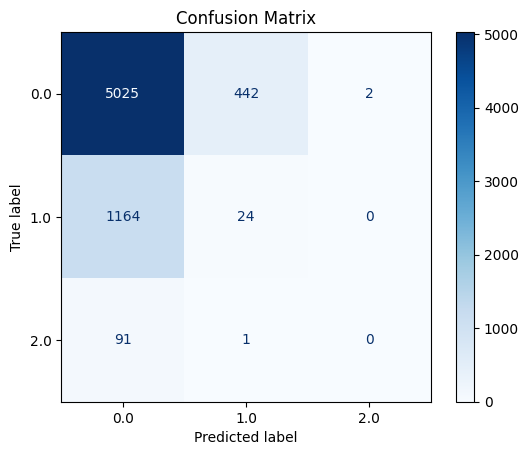

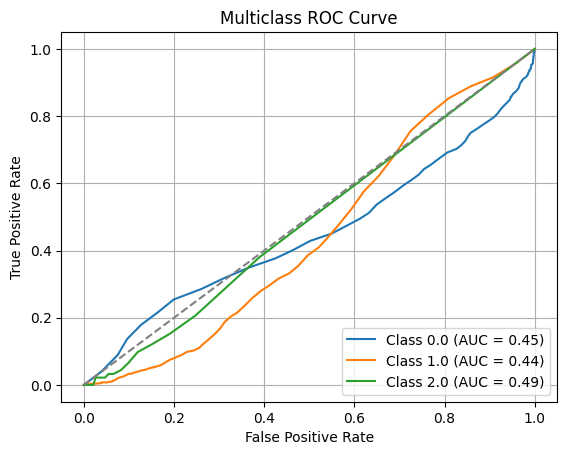

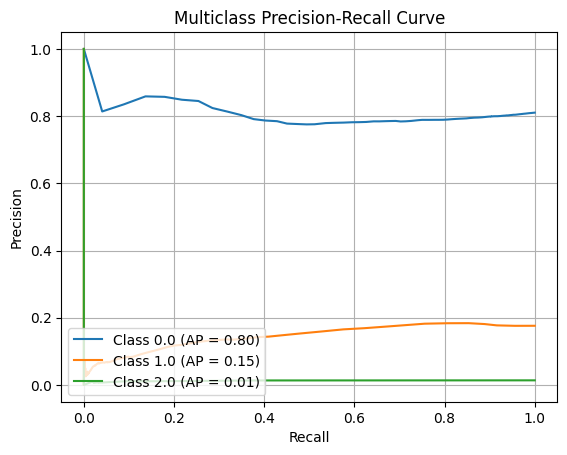

Train  Acc: 1.000,  Validation Acc: 0.751
Train  AUC: 1.000,  Validation AUC: 0.355


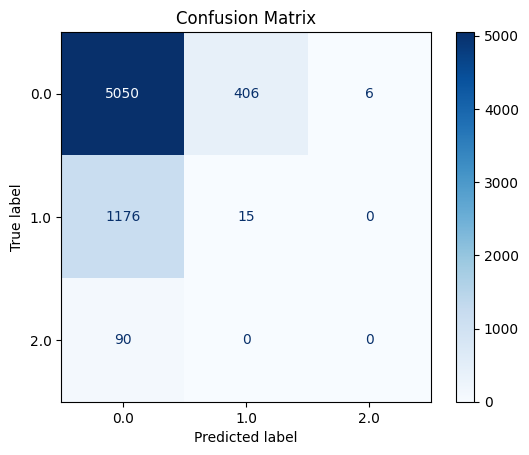

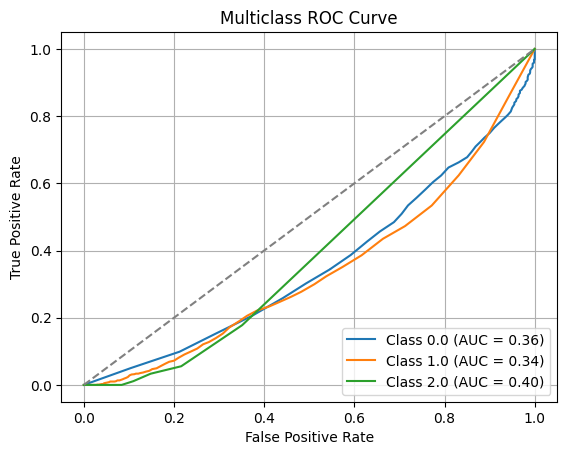

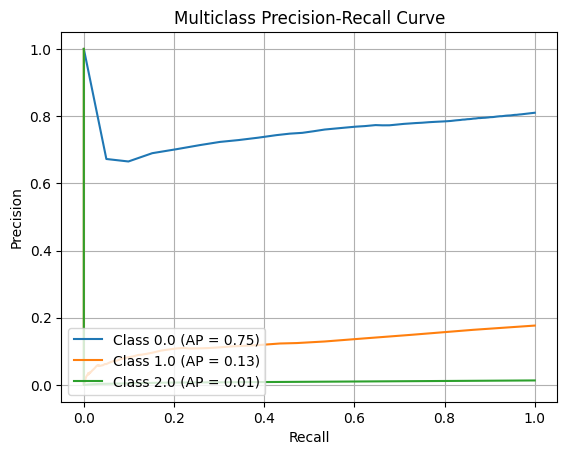

In [21]:
modelsSGK = []
for train_idx, val_idx in sgkf.split(x, targets, groups=groups):
    X_tr, y_tr = x.iloc[train_idx], targets.iloc[train_idx]
    X_vl, y_vl = x.iloc[val_idx], targets.iloc[val_idx]

    model, train_acc, val_acc, train_auc, val_auc = train_evaluate_visualize(
        X_tr, y_tr,
        X_vl, y_vl
    )

    modelsSGK.append(model)

# XGBoost

In [23]:
# Step 1: Get unique user IDs
unique_users = fb_data['fitbit_user_id'].unique()

# Step 2: Split user IDs into train/test
train, test = train_test_split(
    unique_users, test_size=0.2, random_state=42
)

# Step 3: Filter original DataFrame based on user ID
train = fb_data[fb_data['fitbit_user_id'].isin(train)].reset_index(drop=True)
test = fb_data[fb_data['fitbit_user_id'].isin(test)].reset_index(drop=True)

x_train = train[measure_features]
y_train = train[target_col]
x_test = test[measure_features]
y_test = test[target_col]

In [24]:
xgb = XGBClassifier(random_state=42, n_jobs=-1, objective='multi:softprob', num_class=3, eval_metric='mlogloss')

xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=-1, num_class=3, num_parallel_tree=None, ...)

In [25]:
# Predict class and probabilities
y_pred = xgb.predict(x_test)
y_prob = xgb.predict_proba(x_test)

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_prob, multi_class='ovr', average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.7932533733133433
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.96      0.88      5427
         1.0       0.28      0.08      0.12      1168
         2.0       0.00      0.00      0.00        75

    accuracy                           0.79      6670
   macro avg       0.37      0.35      0.34      6670
weighted avg       0.72      0.79      0.74      6670

AUC Score: 0.5764694118479502
Confusion Matrix:
 [[5199  227    1]
 [1076   92    0]
 [  71    4    0]]


CV

In [27]:
x = fb_data[measure_features+['fitbit_user_id']]
targets = fb_data[target_col]

sgkf = StratifiedGroupKFold(n_splits=5)

groups = x['fitbit_user_id']  # or however you track user grouping

In [28]:
xgb = XGBClassifier(random_state=42, n_jobs=-1, objective='multi:softprob', num_class=3, eval_metric='mlogloss')

In [29]:
cross_val_score(xgb, x, targets, groups=groups, cv=sgkf, scoring="accuracy")

array([0.73892706, 0.70468009, 0.72697661, 0.72736702, 0.73053537])

In [30]:
cross_val_score(xgb, x, targets, groups=groups, cv=sgkf, scoring="f1_macro")

array([0.2896695 , 0.28132932, 0.30142071, 0.29499596, 0.29340413])

In [31]:
cross_val_score(xgb, x, targets, groups=groups, cv=sgkf, scoring="f1_weighted")

array([0.68432527, 0.67209807, 0.69170638, 0.68942856, 0.68967897])

In [32]:
cross_val_score(xgb, x, targets, groups=groups, cv=sgkf, scoring="roc_auc_ovr_weighted")

array([0.51597922, 0.43390886, 0.57718595, 0.39166473, 0.36837342])

In [33]:
# Define parameter space
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 4, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=30,  # more = better, but slower
    scoring='f1_macro',
    n_jobs=-1,
    cv=sgkf.split(x, targets, groups=groups),
    verbose=1,
    random_state=42
)

search.fit(x, targets, groups=groups)

print("Best params:", search.best_params_)
print("Best ROC AUC:", search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Best ROC AUC: 0.3027220969650271


In [ ]:
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [2, 3, 4],
    'n_estimators': [150, 200, 250]
}

search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    n_jobs=-1,
    cv=sgkf.split(x, targets, groups=groups),
    verbose=1
)

search.fit(x, targets, groups=groups)

print("Best params:", search.best_params_)
print("Best ROC AUC:", search.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best params: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 150}
Best ROC AUC: nan


In [34]:
best_params = {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.2, 'colsample_bytree': 0.6}

In [35]:
def train_evaluate_visualize(X_train, y_train, X_val, y_val, **params):
    classes = np.unique(y_train)
    model = XGBClassifier(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    y_prob_train = model.predict_proba(X_train)
    y_prob_val = model.predict_proba(X_val)

    train_acc = accuracy_score(y_train, y_pred_train)
    val_acc = accuracy_score(y_val, y_pred_val)
    train_auc = roc_auc_score(y_train, y_prob_train, multi_class='ovr', average='weighted')
    val_auc = roc_auc_score(y_val, y_prob_val, multi_class='ovr', average='weighted')

    print(f"Train  Acc: {train_acc:.3f},  Validation Acc: {val_acc:.3f}")
    print(f"Train  AUC: {train_auc:.3f},  Validation AUC: {val_auc:.3f}")

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred_val, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # Multiclass ROC Curves
    y_val_bin = label_binarize(y_val, classes=classes)
    plt.figure()
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_prob_val[:, i])
        auc_score = roc_auc_score(y_val_bin[:, i], y_prob_val[:, i])
        plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Multiclass PR Curves
    plt.figure()
    for i, class_label in enumerate(classes):
        precision, recall, _ = precision_recall_curve(y_val_bin[:, i], y_prob_val[:, i])
        ap_score = average_precision_score(y_val_bin[:, i], y_prob_val[:, i])
        plt.plot(recall, precision, label=f'Class {class_label} (AP = {ap_score:.2f})')

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Multiclass Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

    return model, train_acc, val_acc, train_auc, val_auc

Train  Acc: 0.919,  Validation Acc: 0.747
Train  AUC: 0.968,  Validation AUC: 0.540


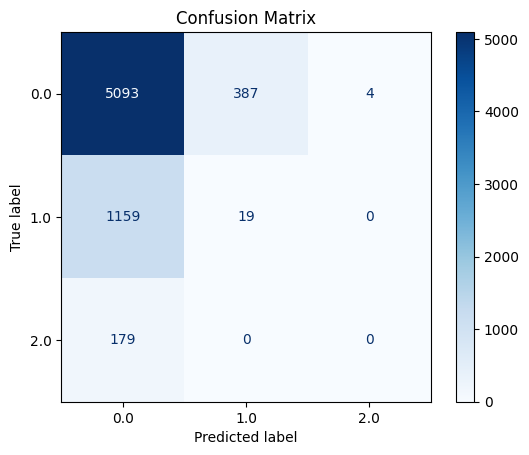

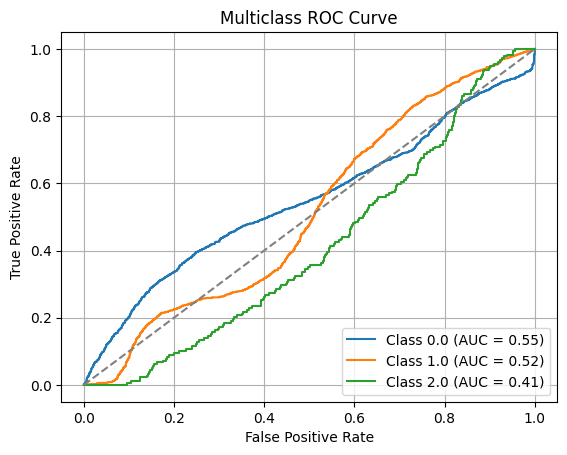

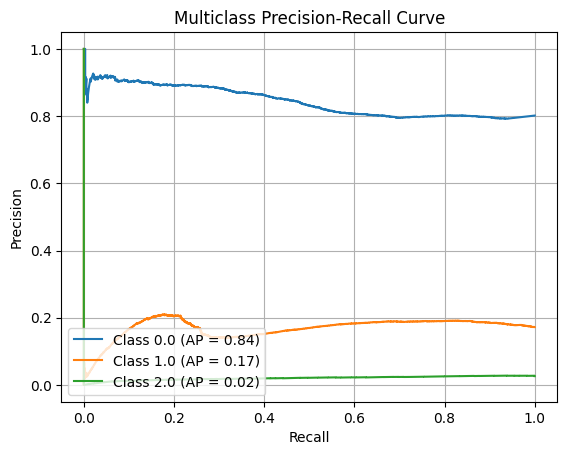

Train  Acc: 0.927,  Validation Acc: 0.728
Train  AUC: 0.972,  Validation AUC: 0.453


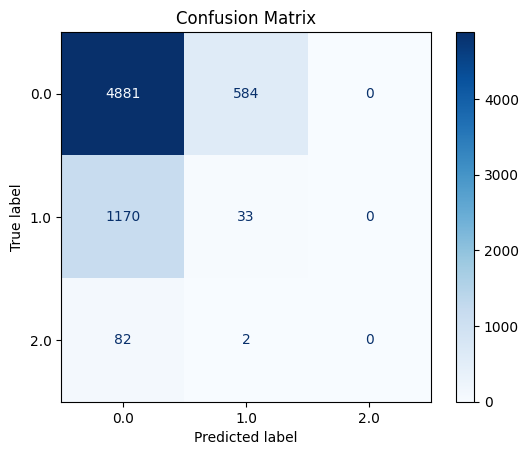

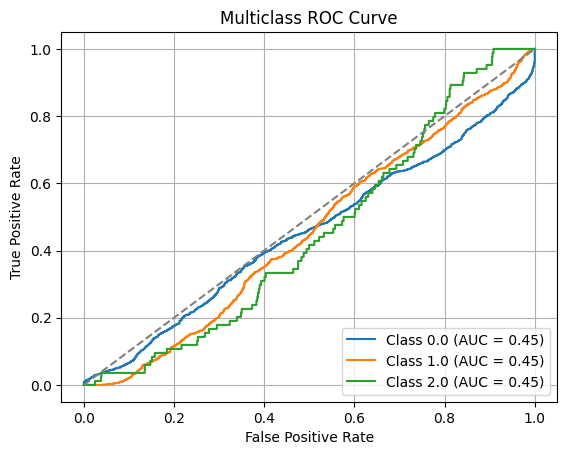

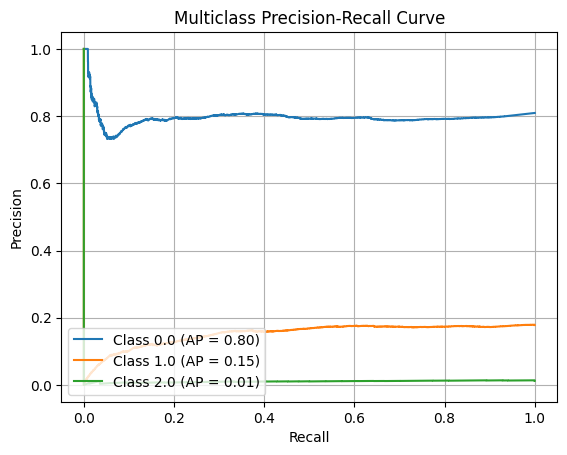

Train  Acc: 0.923,  Validation Acc: 0.714
Train  AUC: 0.972,  Validation AUC: 0.599


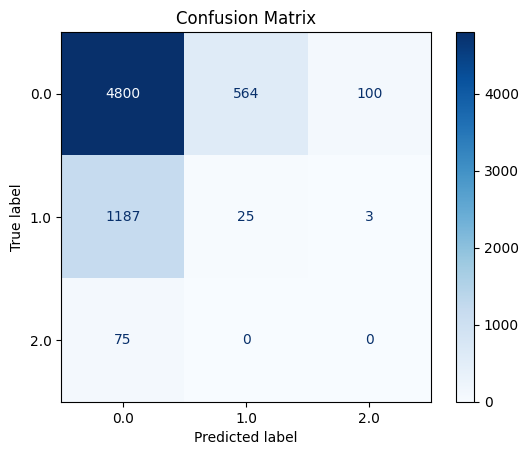

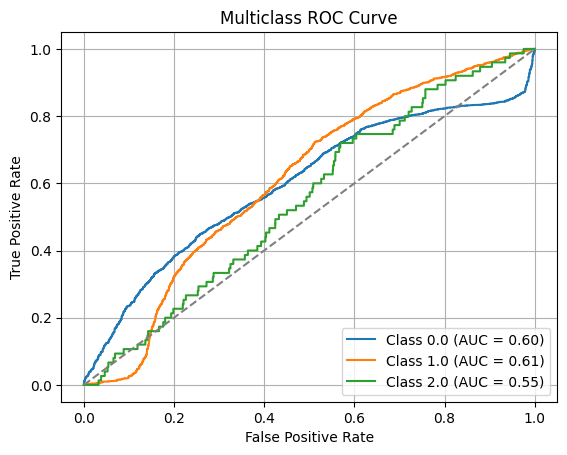

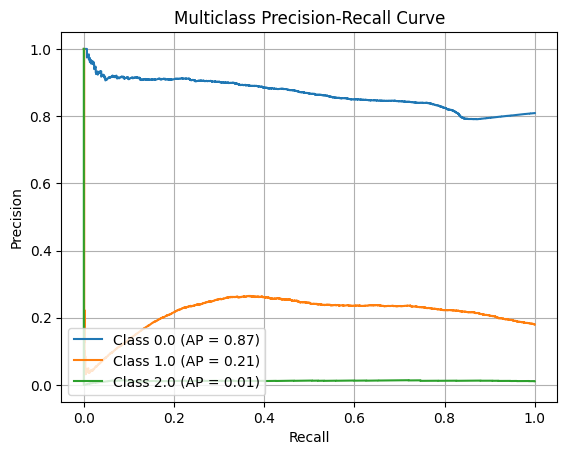

Train  Acc: 0.923,  Validation Acc: 0.722
Train  AUC: 0.969,  Validation AUC: 0.419


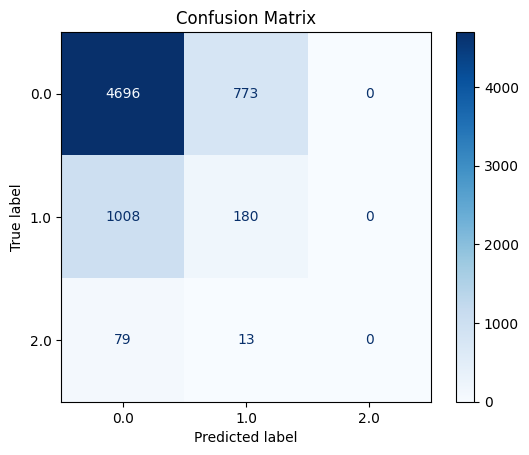

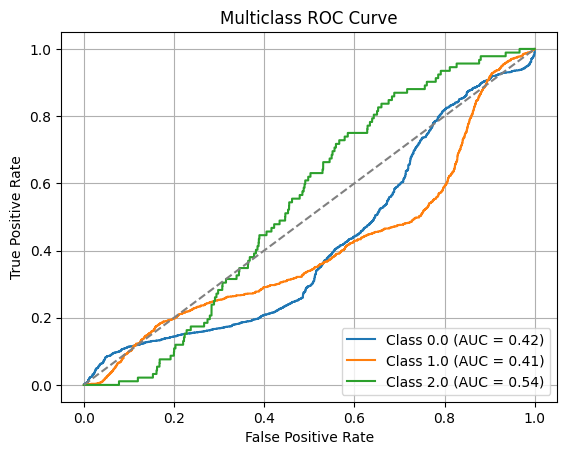

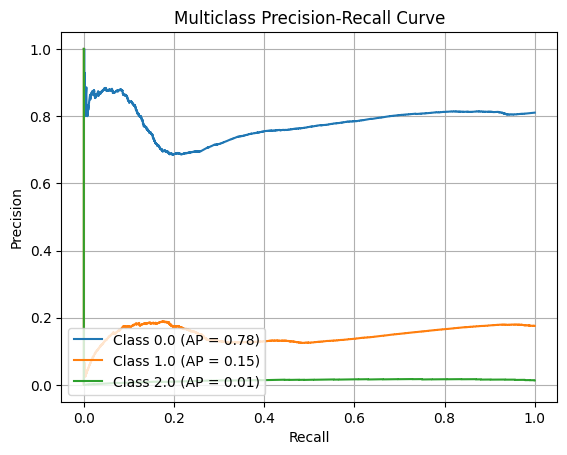

Train  Acc: 0.923,  Validation Acc: 0.739
Train  AUC: 0.970,  Validation AUC: 0.431


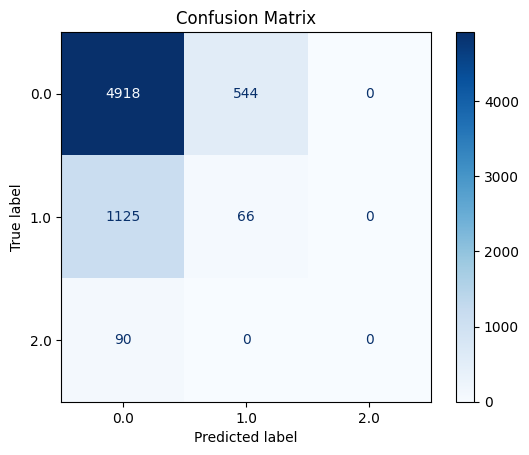

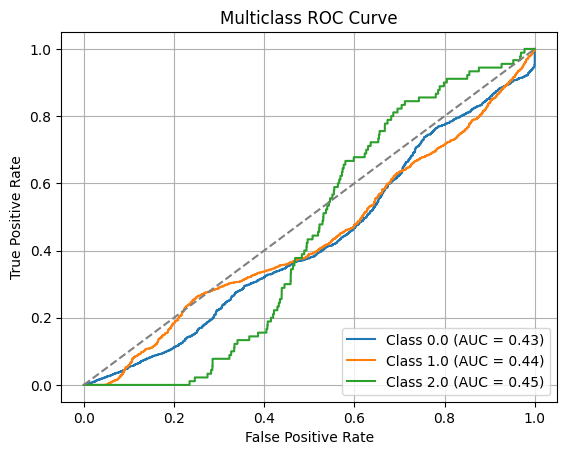

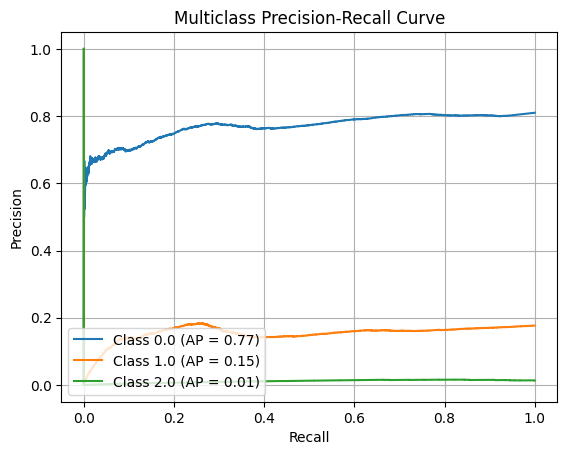

In [36]:
modelsSGK = []
for train_idx, val_idx in sgkf.split(x, targets, groups=groups):
    X_tr, y_tr = x.iloc[train_idx], targets.iloc[train_idx]
    X_vl, y_vl = x.iloc[val_idx], targets.iloc[val_idx]

    model, train_acc, val_acc, train_auc, val_auc = train_evaluate_visualize(
        X_tr, y_tr,
        X_vl, y_vl,
        **best_params
    )

    modelsSGK.append(model)